In [32]:
import sys
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (15,9)

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import NMF
from pathlib import Path

from utils import utils, files, generate_mappings, analysis, plot

# protocol

1. record calibration dataset and extract per-channel variances
2. do NMF on the variance-scaled calibration dataset in order for modes to not be contaminated by channel scales
3. in the center-hold-reach-out task, scale each incoming EMG channel by its calibration variance
4. project filtered center-hold samples onto decoder modes

# load data

In [33]:
experiment = "emg_repeats"
subject = "alba"

movement_session = "1"
calibration_session = "1"
center_hold_session = None # check manually for a folder, default to the first one

subject_metadata_folder = utils.get_subject_folder(experiment=experiment, subject=subject)
assert subject_metadata_folder.exists()
print("subject metadata: ", subject_metadata_folder)

subject metadata:  /mnt/c/Users/spencer/Documents/kyberphysics/metadata/emg_repeats/alba


In [34]:
def load_movement_emg(session_path, movement=None):
    data = {}
    # emg
    emg_paths = sorted(
        [x for x in session_path.iterdir() if x.suffix == ".bin"], key=str)
    for p in emg_paths:
        name = p.name.rstrip(".bin").split("_")[0]
        print(name)
        data.update({name: {}})
        data[name].update(
            {"emg": np.fromfile(p, dtype=np.int32).reshape(-1, 68)})
    # cue
    cue_paths = sorted([x for x in session_path.iterdir() if "cue" in x.name],
                       key=str)
    print(cue_paths)
    for p in cue_paths:
        name = p.name.rstrip(".bin")[:-28]
        cue = np.genfromtxt(str(p), delimiter=',')[:, 2].reshape(-1, 1)
        data[name].update({"cue_raw": cue})
        data[name].update({
            "cue":
            np.round(
                np.interp(
                    np.linspace(0,
                                cue.shape[0],
                                data[name]["emg"].shape[0],
                                endpoint=True), np.arange(cue.shape[0]),
                    cue[:, 0]))
        })
    if movement is None:
        return data
    else:
        return data[movement]

In [35]:
ed = files.build_experiment_path_dict(experiment)
print(ed["subjects"].keys())

if not movement_session is None:
    path = utils.get_session_path(ed, subject, "natural_movement", "session_" + str(movement_session))
    print("movement: ", path)
    md = load_movement_emg(path)
    print("movement: ", md.keys())

if not calibration_session is None:
    path = utils.get_session_path(ed, subject, "calibration_bars", "session_" + str(calibration_session))
    print("calibration: ", path)
    cd = utils.load_calibration_emg(path)
    print("calibration: ", cd.keys())

if not center_hold_session is None:
    path = utils.get_session_path(ed, subject, "center_hold", "session_" + str(center_hold_session))
    print(path)
    chd = utils.load_center_hold_emg(path)
    print("center hold: ", chd.keys())

dict_keys(['alba', 'holly', 'miranda', 'zane'])
movement:  /mnt/c/Users/spencer/data/emg_repeats/alba/natural_movement/session_1
hand closed
hand open
index finger down
index finger up
little finger down
little finger up
middle finger down
middle finger up
ring finger down
ring finger up
wrist down
wrist in
wrist out
wrist up
[PosixPath('/mnt/c/Users/spencer/data/emg_repeats/alba/natural_movement/session_1/hand closed_cue_2021-10-25T11_51_22.csv'), PosixPath('/mnt/c/Users/spencer/data/emg_repeats/alba/natural_movement/session_1/hand open_cue_2021-10-25T11_51_12.csv'), PosixPath('/mnt/c/Users/spencer/data/emg_repeats/alba/natural_movement/session_1/index finger down_cue_2021-10-25T11_49_52.csv'), PosixPath('/mnt/c/Users/spencer/data/emg_repeats/alba/natural_movement/session_1/index finger up_cue_2021-10-25T11_50_02.csv'), PosixPath('/mnt/c/Users/spencer/data/emg_repeats/alba/natural_movement/session_1/little finger down_cue_2021-10-25T11_50_52.csv'), PosixPath('/mnt/c/Users/spencer/data

# highpass and compute variance

In [36]:
high_cutoff = 5

if not movement_session is None:
    concat_movement_data = utils.concat_movement_emg_trials(md)[:,:64]
    concat_movement_data = analysis.highpass(concat_movement_data,cutoff=high_cutoff)
    print(concat_movement_data.shape)
    movement_vars = np.std(concat_movement_data, axis=0)
    movement_means = np.mean(concat_movement_data, axis=0)


(252000, 64)


In [37]:

if not calibration_session is None:
    concat_calibration_data = utils.concat_emg_trials(cd)[:,:64]
    concat_calibration_data = analysis.highpass(concat_calibration_data,cutoff=high_cutoff)
    print(concat_calibration_data.shape)
    calibration_vars = np.std(concat_calibration_data, axis=0)
    calibration_means = np.mean(concat_calibration_data, axis=0)


(768000, 64)


# inspect data

-1.5207440825607945 106.42084330729146
min channel:  15
0.0013736318654574292 106.42084330729146
(251999, 64)


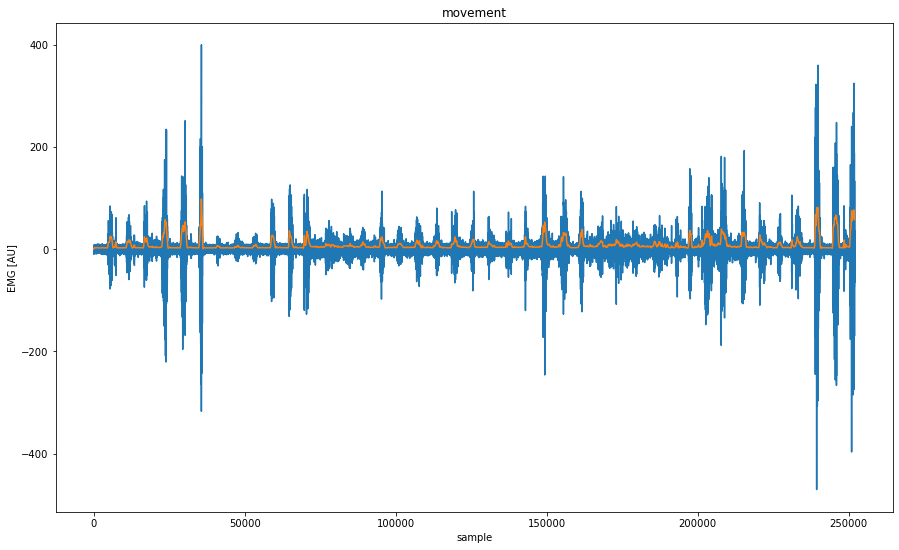

In [38]:
# plot one trial

low_cutoff = 5
start = 0
stop = -1
channel = 55

if not movement_session is None:
    plt.figure()
    hp = concat_movement_data[start:stop]
    lp = utils.filter_emg(hp)
    plt.plot(hp[:,channel])
    plt.plot(lp[:,channel])
    plt.title("movement")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")


-1.6583360713736053 166.98538122425998
min channel:  11
0.00027230379990969355 166.98538122425998
(767999, 64)


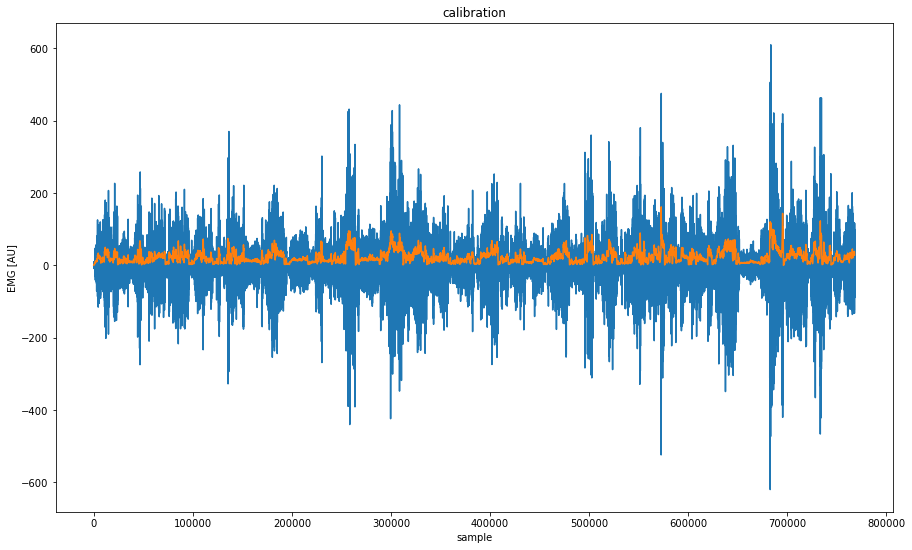

In [39]:

if not calibration_session is None:
    plt.figure()
    hp = concat_calibration_data[start:stop]
    r = analysis.rectify(hp)
    lp = utils.filter_emg(hp)
    plt.plot(hp[:,channel])
    # plt.plot(r[:,channel])
    plt.plot(lp[:,channel])
    plt.title("calibration")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")


# inspect mean and var

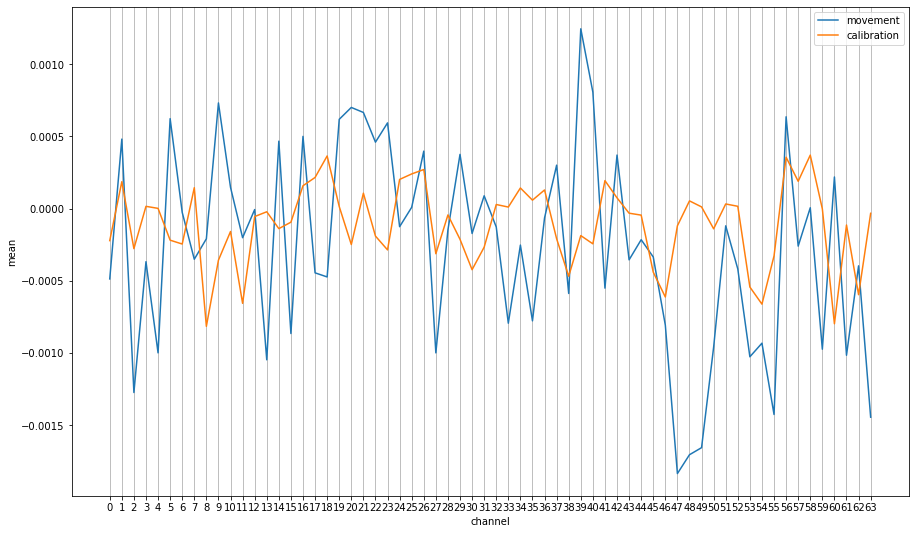

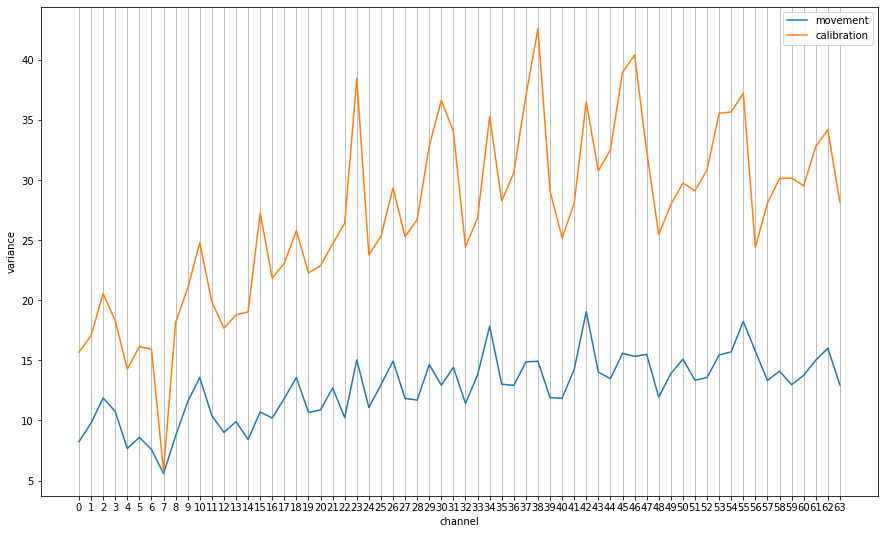

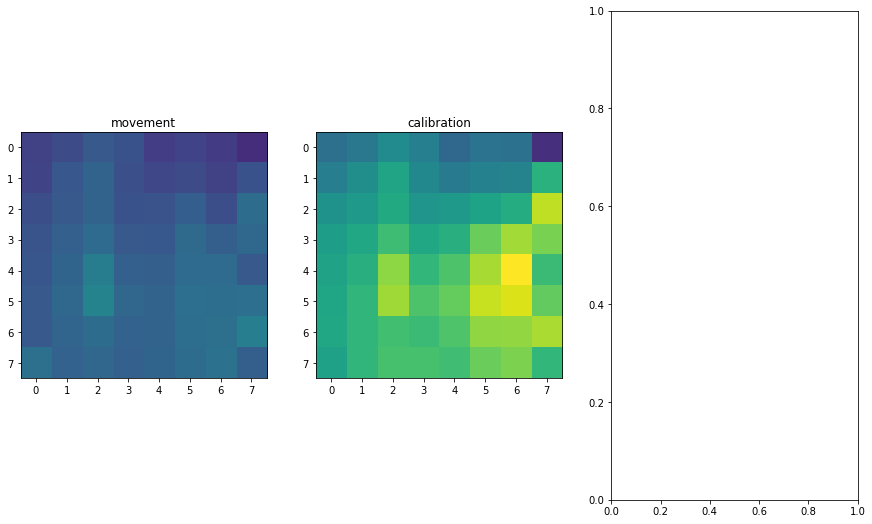

In [40]:
# mean
plt.figure()
if not movement_session is None:
    plt.plot(movement_means, label="movement")
if not calibration_session is None:
    plt.plot(calibration_means, label="calibration")
if not center_hold_session is None:
    plt.plot(center_hold_means, label="center hold")
plt.xticks(range(64))
plt.grid(which="both", axis="x")
plt.xlabel("channel")
plt.ylabel("mean")
plt.legend()

# variance
plt.figure()
if not movement_session is None:
    plt.plot(movement_vars, label="movement")
if not calibration_session is None:
    plt.plot(calibration_vars, label="calibration")
if not center_hold_session is None:
    plt.plot(center_hold_vars, label="center hold")
plt.xticks(range(64))
plt.grid(which="both", axis="x")
plt.xlabel("channel")
plt.ylabel("variance")
plt.legend()

maxes = []
if not movement_session is None:
    maxes.append(np.max(movement_vars))
if not calibration_session is None:
    maxes.append(np.max(calibration_vars))
if not center_hold_session is None:
    maxes.append(np.max(center_hold_vars))
maxmax = np.max(maxes)

fig, axes = plt.subplots(1,3)
if not movement_session is None:
    axes[0].imshow(movement_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[0].set_title("movement")
if not calibration_session is None:
    axes[1].imshow(calibration_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[1].set_title("calibration")
if not center_hold_session is None:
    axes[2].imshow(center_hold_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[2].set_title("center hold")

# compute and save variance scaling from calibration

In [41]:
v = np.diag(np.array(calibration_vars**-1, dtype=np.float32))
print(v)
print(v.shape)

# save scaling 
utils.write_array_to_disk(a=v,path=subject_metadata_folder / "variance.bin")

[[0.06376713 0.         0.         ... 0.         0.         0.        ]
 [0.         0.05858624 0.         ... 0.         0.         0.        ]
 [0.         0.         0.04867342 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.03051848 0.         0.        ]
 [0.         0.         0.         ... 0.         0.02926298 0.        ]
 [0.         0.         0.         ... 0.         0.         0.03554708]]
(64, 64)


# compute offsets from movement

5
(18000, 64)
-0.05744120133613495 1.9641515976470219
min channel:  4
5.394019355839867e-05 1.9641515976470219
(18000, 64)


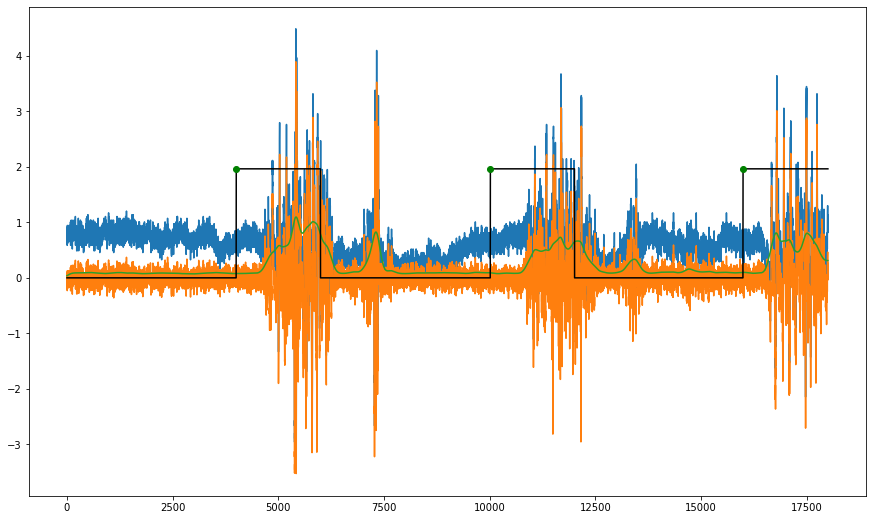

In [42]:
movements = list(md.keys())

signals = md[movements[0]]["emg"][:,:64]
print(high_cutoff)

std = utils.standardize(signals,calibration_vars)
# print(std.shape)
hp = analysis.highpass(std,cutoff=high_cutoff)
# print(r.shape)
lp = utils.filter_emg(hp)
# print(lp.shape)
cue = md[movements[0]]["cue"]
cue_on_indices = utils.get_cue_on_indices(cue)

channel = 43

plt.figure()
plt.plot(std[:,channel])
plt.plot(hp[:,channel])
plt.plot(lp[:,channel])
plt.plot(cue*np.max(lp),"k")
plt.plot(cue_on_indices,np.max(lp)*np.ones(shape=(cue_on_indices.shape[0])),'go')

(21000, 64)
(21000, 64)
-0.04364083827285149 1.1862549326140033
min channel:  60
0.00014585478299240228 1.1862549326140033
(21000, 64)
offset shape: (64, 1)
peak offset channel  7


Text(0.5, 1.0, 'quiescents')

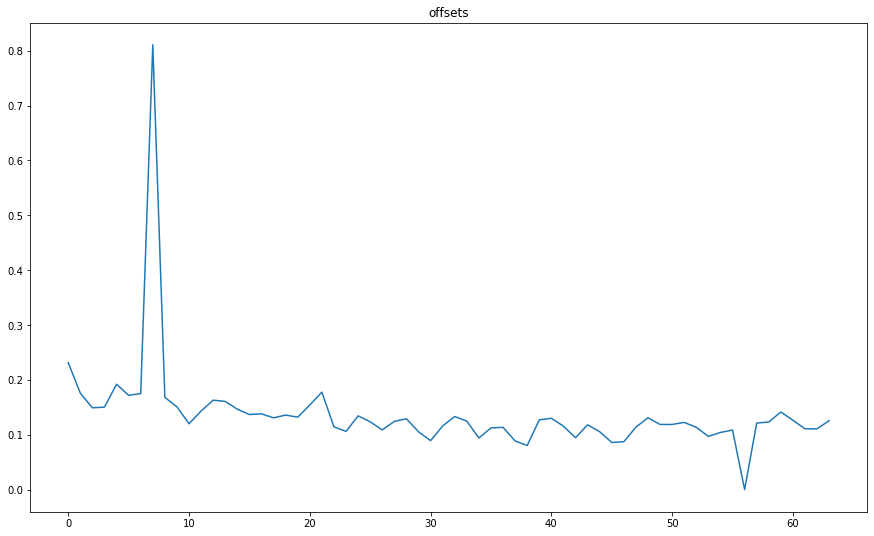

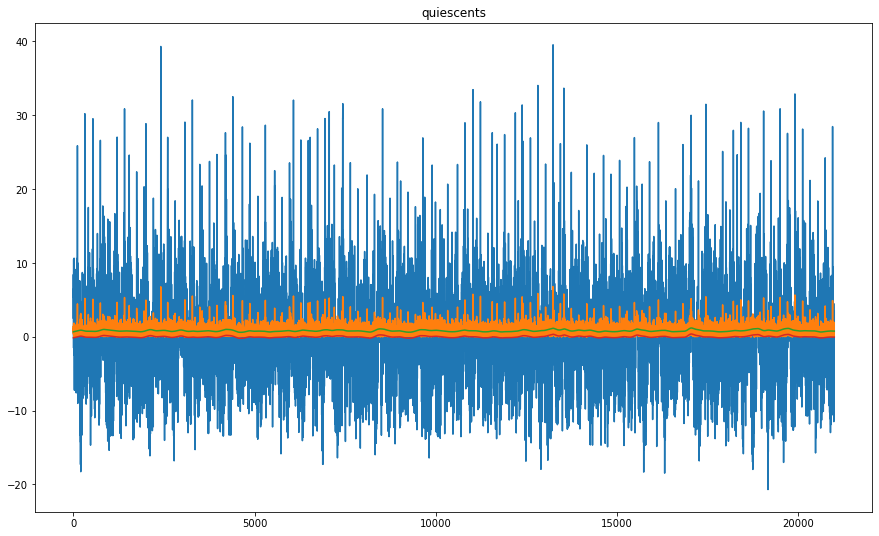

In [43]:
concat_quiescent_trials = utils.extract_quiescent(md)
print(concat_quiescent_trials.shape)

standardized_concat_quiescent_trial = utils.standardize(concat_quiescent_trials, calibration_vars)
r = analysis.rectify(standardized_concat_quiescent_trial)
lp = utils.filter_emg(standardized_concat_quiescent_trial)

offsets = np.mean(lp,axis=0).reshape(64)
# channel 56 is broken :(
offsets[56] = 0

offsets = np.array(offsets,dtype=np.float32).reshape(-1,1)
print("offset shape:", offsets.shape)

channel = np.argmax(offsets)
print("peak offset channel ", channel)

plt.figure()
plt.plot(offsets)
plt.title("offsets")

plt.figure()
plt.plot(concat_quiescent_trials[:,channel])
plt.plot(r[:,channel])
plt.plot(lp[:,channel])
plt.plot((lp-offsets.reshape(-1))[:,channel])
plt.title("quiescents")

# save offsets

In [44]:
utils.write_array_to_disk(offsets.reshape(-1,1),subject_metadata_folder / "offsets.bin")

# standardize (variance), filter, shift (offset)

In [45]:
channel = 29
end = 40000

(768000, 64)
-0.08347259776853996 4.836291805932943
min channel:  11
7.3164609621379705e-06 4.836291805932943
(768000, 64)


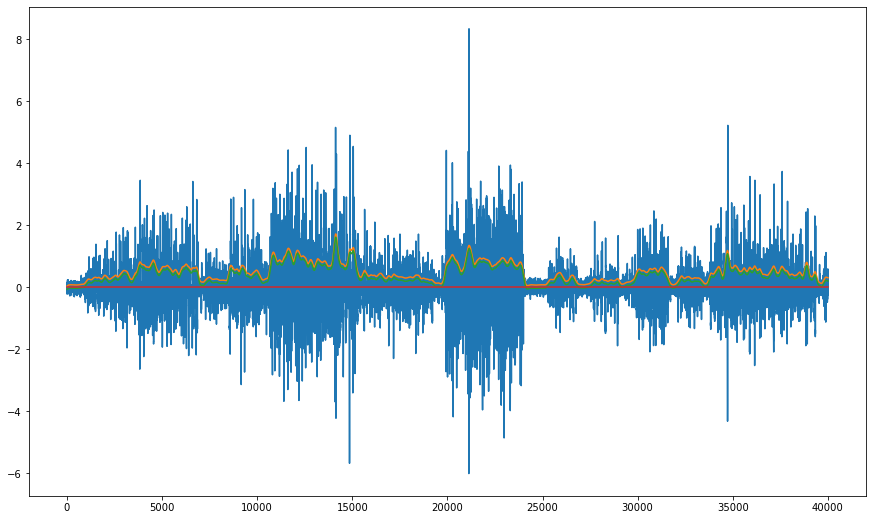

In [46]:
standardized_calibration_data = utils.standardize(concat_calibration_data, calibration_vars)
filtered_calibration_data = utils.filter_emg(standardized_calibration_data)
offset_calibration_data = np.subtract(filtered_calibration_data,offsets.reshape(-1))
plt.plot(standardized_calibration_data[:end,channel])
plt.plot(filtered_calibration_data[:end,channel])
plt.plot(offset_calibration_data[:end,channel])
if end == -1:
    plt.plot([0,filtered_calibration_data.shape[0]],[0,0])
else:
    plt.plot([0,end],[0,0])

# movement

(252000, 64)
-0.05744120133618341 4.187994746256574
min channel:  4
5.394019356596968e-05 4.187994746256574
(252000, 64)


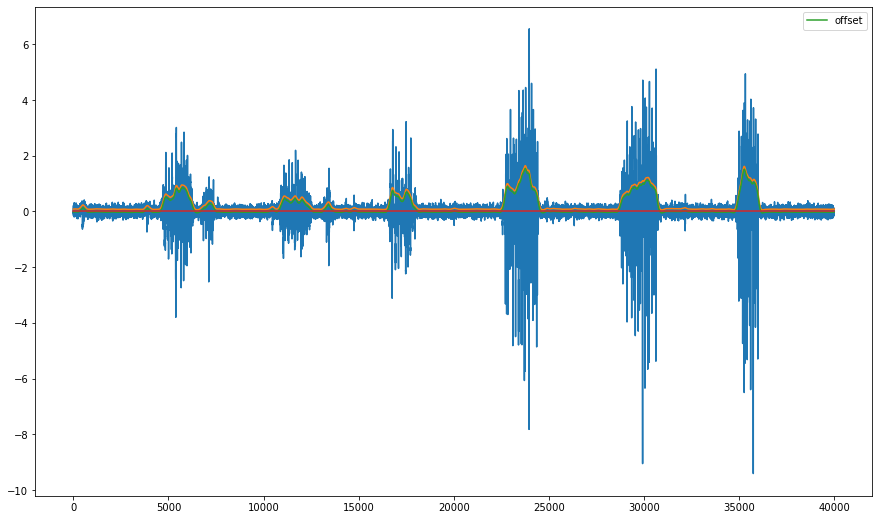

In [47]:
standardized_movement_data = utils.standardize(concat_movement_data, calibration_vars)
filtered_movement_data = utils.filter_emg(standardized_movement_data)
offset_movement_data = np.subtract(filtered_movement_data, offsets.reshape(-1))
plt.plot(standardized_movement_data[:end,channel])
plt.plot(filtered_movement_data[:end,channel])
plt.plot(offset_movement_data[:end,channel],label="offset")
if end == -1:
    plt.plot([0,filtered_movement_data.shape[0]],[0,0])
else:
    plt.plot([0,end],[0,0])
plt.legend()

# center hold

In [48]:
if not center_hold_session is None:
    standardized_center_hold_data = utils.standardize(concat_center_hold_data, calibration_vars)
    filtered_center_hold_data = utils.filter_emg(standardized_center_hold_data)
    offset_center_hold_data = np.subtract(filtered_center_hold_data,offsets)
    plt.plot(standardized_center_hold_data[:end,channel])
    plt.plot(filtered_center_hold_data[:end,channel])
    plt.plot(offset_center_hold_data[:end,channel],label="offset")
    if end == -1:
        plt.plot([0,filtered_center_hold_data.shape[0]],[0,0])
    else:
        plt.plot([0,end],[0,0])
    plt.legend()

# NMF

we L1-regularize the output (the projection of the data, W) to encourage the decoder to allow for single modes to be active at once

we can check this by looking at the correlation between the transformed data and seeking the least correlated projections

$$WH   =  X$$

TxK x Kx64 = Tx64

transformation x components = data

factors x weights = data

inverse:

$$W = XH^{-1}$$
$$W^T = H^{-T}X^T$$

KxT = Kx64 x 64xT

In [49]:
num_nmf_components = 4
nmf_model = NMF(n_components=num_nmf_components, max_iter=500, l1_ratio=0.9, regularization="transformation", random_state=0)
nmf_model.fit(filtered_calibration_data)

/home/spencer/miniconda3/envs/motor/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/spencer/miniconda3/envs/motor/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF(l1_ratio=0.9, max_iter=500, n_components=4, random_state=0,
    regularization='transformation')

In [50]:
nmf_components = nmf_model.components_
factors = nmf_model.transform(filtered_calibration_data)
print("components: ", nmf_components.shape)
print("factors: ", factors.shape)

norms = np.linalg.norm(nmf_components,axis=1).reshape(num_nmf_components,1)
normalized_nmf_components = np.divide(nmf_components, norms)
print(normalized_nmf_components.shape)

components:  (4, 64)
factors:  (768000, 4)
(4, 64)


# plot components and factors

0.0 0.3364834445247837


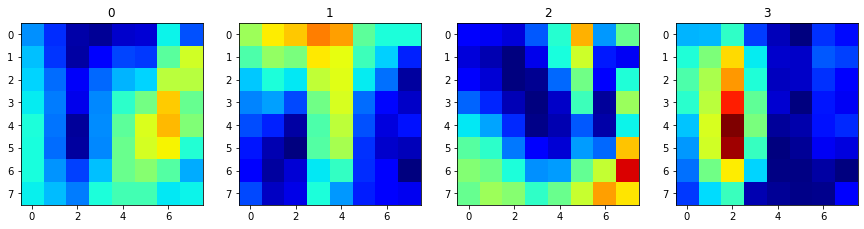

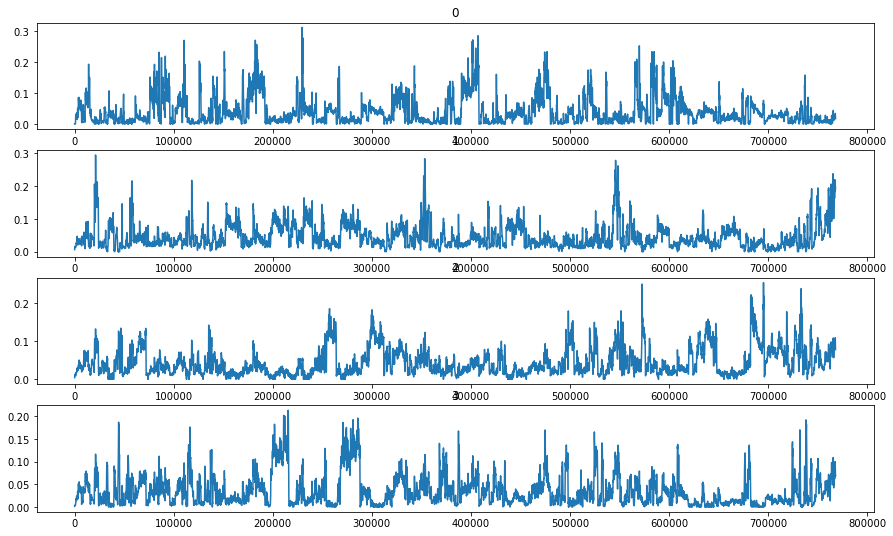

In [51]:
fig, axes = plt.subplots(1,num_nmf_components)
for i, (ax, c) in enumerate(zip(axes,normalized_nmf_components)):
    ax.imshow(c.reshape(8,8),vmin=0,vmax=np.max(normalized_nmf_components),cmap="jet")
    ax.set_title(i)
print(np.min(normalized_nmf_components),np.max(normalized_nmf_components))

fig, axes = plt.subplots(num_nmf_components,1)
for i, (ax, c) in enumerate(zip(axes,factors.T)):
    ax.plot(c)
    ax.set_title(i)


# compute inverse components

In [52]:
inv_components = np.linalg.pinv(normalized_nmf_components).T
print(inv_components.shape)
inv_norms = np.linalg.norm(inv_components,axis=1).reshape(num_nmf_components,1)
print(inv_norms.shape)
normalized_inv_components = np.divide(inv_components, inv_norms)

(4, 64)
(4, 1)


# plot inverse components and factors

-0.24914925267076143 0.3990167940399544 0.02694390868993302


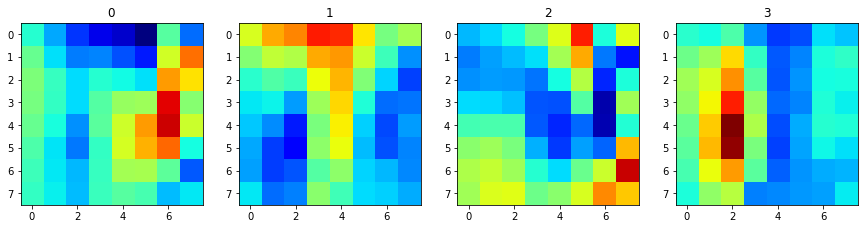

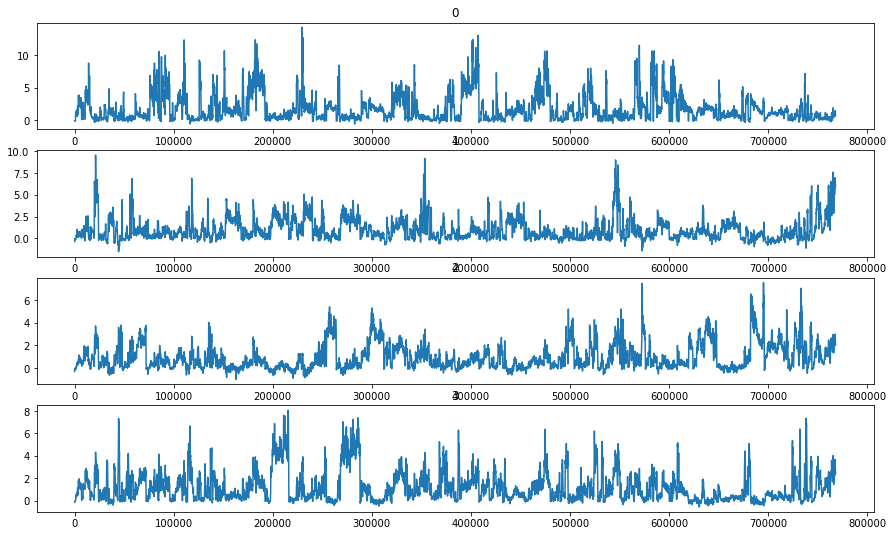

In [53]:
fig, axes = plt.subplots(1,num_nmf_components)
for i, (ax, c) in enumerate(zip(axes,normalized_inv_components)):
    ax.imshow(c.reshape(8,8),vmin=np.min(normalized_inv_components),vmax=np.max(normalized_inv_components),cmap="jet")
    ax.set_title(i)
print(np.min(normalized_inv_components),np.max(normalized_inv_components), np.mean(normalized_inv_components))

inverse_factors = np.dot(inv_components, offset_calibration_data.T)
fig, axes = plt.subplots(num_nmf_components,1)
for i, (ax, c) in enumerate(zip(axes,inverse_factors)):
    ax.plot(c)
    ax.set_title(i)

# compute decoder

In [56]:
component_idxs = [2,1,3,0]

In [57]:
# make decoder (right,left,down,up)
decoder = np.array(normalized_inv_components[component_idxs],dtype=np.float32)
print(decoder.shape)

# convert to 2D (subtract right-left up-down)
convert_to_2d = np.array([[1,-1,0,0],[0,0,-1,1]])
print(convert_to_2d)
two_dim_decoder = np.dot(convert_to_2d, decoder)
print(two_dim_decoder.shape)

# add other state variables
six_dim_decoder = np.array(np.vstack([np.zeros(shape=(4,64)), two_dim_decoder]),dtype=np.float32)
print(six_dim_decoder.shape)
print(six_dim_decoder.dtype)

(4, 64)
[[ 1 -1  0  0]
 [ 0  0 -1  1]]
(2, 64)
(6, 64)
float32


# compute dynamics

In [58]:
# add the dynamics
experiment_metadata_dict = utils.get_experiment_metadata("emg_olympics")
dynamics = generate_mappings.generate_dynamics(decay=experiment_metadata_dict["decay"], tau=experiment_metadata_dict["tau"], stiffness=experiment_metadata_dict["stiffness"])
print(dynamics)

[[ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]
 [-0.  0.  0.  0.  0.  0.]
 [ 0. -0.  0.  0.  0.  0.]]


# plot dynamics

No handles with labels found to put in legend.


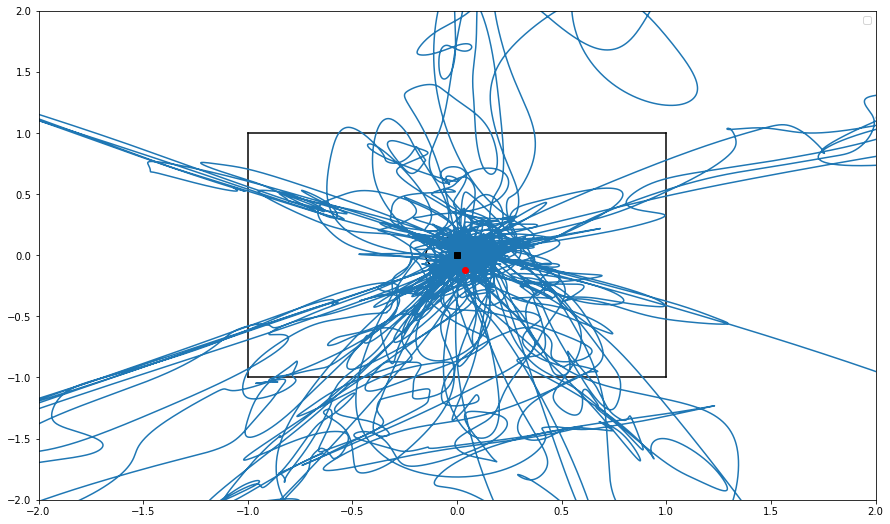

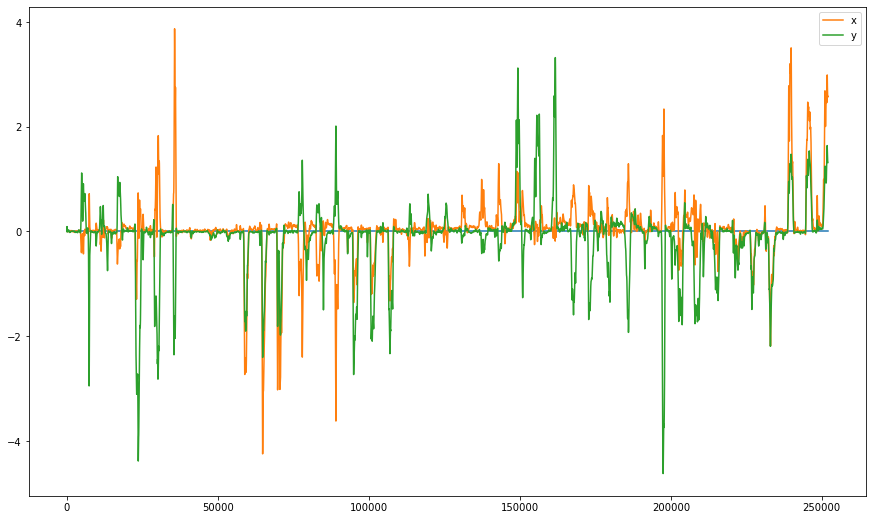

In [59]:
def plot_circle(x,y,r,ax,style="k"):
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(r*np.cos(theta)+x, r*np.sin(theta)+y,style)
    
def plot_box(ax):
    ax.plot(0,0,'ks',zorder=20)
    plot_circle(0,0,.15,ax)
    ax.plot([-1,1],[-1,-1],"k")
    ax.plot([-1,1],[1,1],"k")
    ax.plot([1,1],[-1,1],"k")
    ax.plot([-1,-1],[-1,1],"k")
    
def plot_control_preview(data, decoder, ax, label=""):
    ax.plot(np.dot(decoder[-1:],data.T)[0],np.dot(decoder[-2:-1],data.T)[0],label=label)
    ax.plot(np.dot(decoder[-1:],data.T)[0].mean(),np.dot(decoder[-2:-1],data.T)[0].mean(),"o",label=label+"mean",zorder=10)

def plot_dynamics_preview(data, dynamics, decoder, label=""):
    fig, ax = plt.subplots(1,1)
    states = []
    state = np.zeros(shape=(6,1))
    for sample in data:
        state = utils.advance_dynamics(dynamics,state,decoder,sample.reshape(-1,1))
        states.append(state)
    states = np.hstack(states)
    ax.set_ylim([-2,2])
    ax.set_xlim([-2,2])
    plot_box(ax)
    # plot_control_preview(offset_movement_data, decoder, ax)
    ax.plot(states[0],states[1])
    ax.plot(states[0].mean(),states[1].mean(),"ro")
    ax.legend()
    return states
    
states = plot_dynamics_preview(offset_movement_data, dynamics, six_dim_decoder, label="movement")

fig, ax = plt.subplots(1,1)
ax.plot([0, states.shape[1]],[0,0])
ax.plot(states[0],label="x")
ax.plot(states[1],label="y")
ax.legend()
ax.legend()


# save decoder

In [60]:
utils.write_array_to_disk(six_dim_decoder, subject_metadata_folder / "decoder.bin")

# save dynamics

In [61]:
utils.write_array_to_disk(dynamics, subject_metadata_folder / "dynamics.bin")
print(utils.load_array_from_disk(subject_metadata_folder / "dynamics.bin").reshape(6,-1))

[[ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]
 [-0.  0.  0.  0.  0.  0.]
 [ 0. -0.  0.  0.  0.  0.]]


# save model and components

In [62]:
with open(subject_metadata_folder / "nmf_model.pkl", 'wb') as fp:
    pickle.dump(nmf_model, fp)

subject_metadata_dict = utils.get_subject_metadata(experiment,subject)
subject_metadata_dict.update({"components":component_idxs})

with open(str(utils.get_subject_folder(experiment,subject)/"metadata.json"), mode="w") as fp:
    json.dump(subject_metadata_dict, fp)

utils.get_subject_metadata(experiment,subject)

{'name': 'alba', 'components': [2, 1, 3, 0]}

# load and test decoder

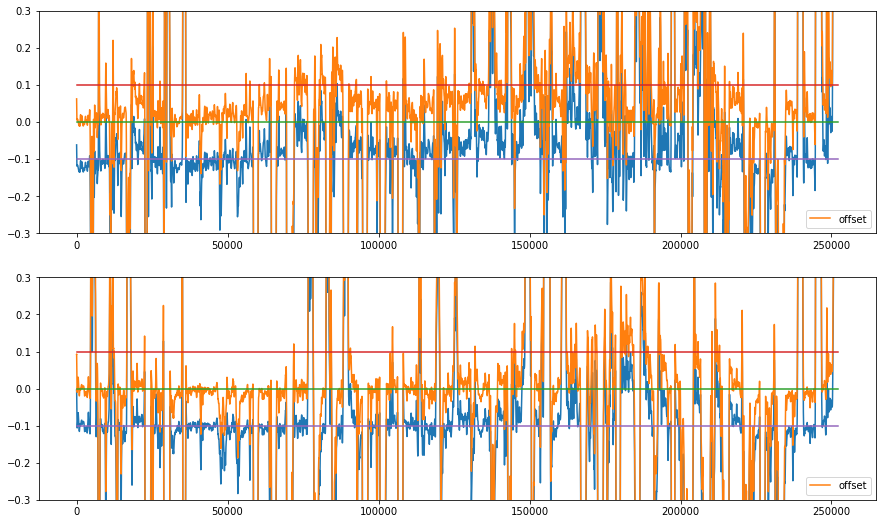

In [63]:
decoder = utils.load_array_from_disk(subject_metadata_folder / "decoder.bin").reshape(6,64)

end = -1
# 2D preview
fig, axes = plt.subplots(2,1)
for ax, c in zip(axes,decoder[-2:]):
    baseline = np.dot(c,filtered_movement_data.T)
    ax.plot(baseline[:end])
    baseline = np.dot(c,offset_movement_data.T)
    ax.plot(baseline[:end],label="offset")
    ax.plot([0,baseline[:end].shape[0]],[0,0])
    ax.plot([0,baseline[:end].shape[0]],[0.1,0.1])
    ax.plot([0,baseline[:end].shape[0]],[-0.1,-0.1])
    ax.legend()
    ax.set_ylim([-0.3,0.3])

# load and test model

In [64]:
with open(subject_metadata_folder / "nmf_model.pkl", 'rb') as fp:
    m = pickle.load(fp)

subject_metadata = utils.get_subject_metadata(experiment, subject)
nmf_components = m.components_[subject_metadata["components"]]
print(nmf_components.shape)

(4, 64)


In [36]:
# fig, axes = plt.subplots(1,2)

# # mode covariance
# axes[0].imshow(normalized_nmf_components@normalized_nmf_components.T,vmin=0,vmax=1,cmap="jet")

# # factor covariance
# c = normalized_factors.T@normalized_factors
# print(c.min(),c.max())
# axes[1].imshow(c,vmin=0,vmax=1,cmap="jet")x